Seq2Seq 기계번역

- RNN 기반의 번역모델로 기계번역의 새로운 패러다임을 열었다고 할 정도로 뛰어난 성능 보여줌
- 시퀀스를 입력받아 또 다른 시퀀스를 출력 ( 문장을 다른 문장으로 번역 )
- 이와 같은 모델이 능력 학습 위해선 병렬 말뭉치라고 하는 원문과 번역문이 쌍을 이루는 형태의 많은 데이터가 필요하다. 
- Seq2Seq는 각자 다른 역할을 하는 두 개의 RNN을 이어붙인 모델이다. 
- 이번 예제는 간소화하여 진행 
- 두 모델은 각 인코더와 디코더 라는 두 RNN을 부여한다. 
- 인코더는 원문의 내용을 학습하는 RNN으로 원문의 단어를 입력받아 문장의 뜻을 내포하는 하나의 고정크기 텐서를 만들어낸다. (문맥벡터)
- 디코더는 문맥벡터를 이어받아 번역문 속의 토큰을 차례대로 예상한다. 

In [1]:
#라이브러리 임포트 
#간소화시킨 예제로 단어 단위가 아닌 글자단위로 임베딩 진행
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

#데이터 속에 몇종류의 토큰이 있는지 정의
vocab_size = 256  # 총 아스키 코드 개수 ( 영문만 다룰 것이기 때문에, 영문을 숫자로 표현하는 아스킼 코드로 임베딩)

x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

#원문과 번역문을 아스키 코드의 배열로 정의하고 텐서로 변환
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [2]:
class Seq2Seq(nn.Module):
    #동작 필요함수 구현
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)#hidden_size를 임베딩된 토큰이ㅡ 차원값으로 정의 
        #원문과 번역문의 문자 체계가 다른 경우는 원문, 번역문용 임베딩을 따로 만들어야 한다. (이번 경우는 둘다 아스키코드 이용가능)
        self.encoder = nn.GRU(hidden_size, hidden_size)#인코더 
        self.decoder = nn.GRU(hidden_size, hidden_size)#디코더 
        #디코더가 번역문의 다음 토큰을 예상하는 ㄴ신경망
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1) #입력되는 원문을 구성하는 모든 문자 임베딩
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력
        decoder_state = encoder_state #디코더의 첫 은닉벡터로 지정
        decoder_input = torch.LongTensor([0]) #디코더가 번역문의 첫 토큰 예상을 위해서는 인코더의 문맥 벡터와 문장 시작토큰을 입력데이터로 받아야한다. 
                                                #문장시작토큰은 실제 문장에는 나타나지 않지만, 디코더의 작동을 위해 인위적으로 넣은 토큰(문장 시작을 알리기위함 - 0설정)
        
        # 디코더 (Decoder)
        outputs = []
        
        #순서대로 예상하고 저장하기 위한 반복문
        for i in range(targets.size()[0]):
            #첫 토큰과 인코더의 문맥벡터를 동시에 입력받음
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            #디코더의 출력값을 다시 입력력되어 신경망 마지막 층을 거치며 다음 예상겨로가가 나오고 이 결과를 ouputs텐서에 저장해 오차계산시 사용
            projection = self.project(decoder_output)
            outputs.append(projection)
            
            #티처 포싱(Teacher Forcing) 사용
            #디코더 학습 시, 실제 번역문의 토큰을 디코더의 전 출력값 대신 입력으로 사용해 학습을 가속화하는 방법
            #잘못 예측 토큰이 사용되는 것을 방지하기 위해 이용
            decoder_input = torch.LongTensor([targets[i]])
        #번역문의 모든 토큰에 대한 결과값들이 배열 반환
        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [4]:
seq2seq = Seq2Seq(vocab_size, 16)
criterion = nn.CrossEntropyLoss() #교차 엔트로피 오차이용
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3) #최적화알고리즘

In [5]:
log = []

#천번의 EPOCHS 학습 
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차: 5.640087127685547
['ú', '·', 'ú', 'î']

 반복:100 오차: 2.065296173095703
['l', 'l', 'l', 'a']

 반복:200 오차: 0.6980044841766357
['h', 'o', 'l', 'a']

 반복:300 오차: 0.37087923288345337
['h', 'o', 'l', 'a']

 반복:400 오차: 0.24537064135074615
['h', 'o', 'l', 'a']

 반복:500 오차: 0.17850184440612793
['h', 'o', 'l', 'a']

 반복:600 오차: 0.13711902499198914
['h', 'o', 'l', 'a']

 반복:700 오차: 0.10922811925411224
['h', 'o', 'l', 'a']

 반복:800 오차: 0.08933883905410767
['h', 'o', 'l', 'a']

 반복:900 오차: 0.07456357777118683
['h', 'o', 'l', 'a']


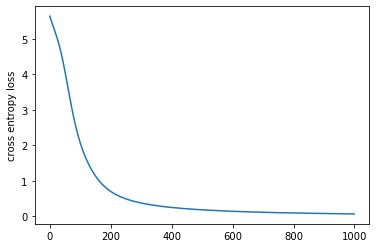

In [6]:
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()

오차가 줄어들며 원문hello의 결과가 hola로 변화함